# Data Generation using Modelling and Simulation for Machine Learning

## Bank Queue Simulation using SimPy

This project demonstrates the use of computer simulation to generate synthetic
data for machine learning applications. A bank queue system is modelled using
the SimPy discrete-event simulation library. The generated simulation data is
used to train and evaluate multiple machine learning models.

In [1]:
!pip install simpy

In [3]:
import simpy
import random
import pandas as pd
import numpy as np

## Simulation Model Description

The simulation represents a bank with a fixed number of service counters.
Customers arrive at the bank at random intervals, wait in a queue if all servers
are busy, get serviced, and then leave.

### Key Parameters:
- Arrival rate: average time between customer arrivals
- Service rate: average time taken to serve a customer
- Number of servers
- Simulation time

The main performance metric recorded is the average waiting time of customers.

In [4]:
def bank_customer(env, name, bank, service_time, waiting_times):
    arrival_time = env.now
    with bank.request() as request:
        yield request
        wait = env.now - arrival_time
        waiting_times.append(wait)
        yield env.timeout(service_time)


def run_simulation(arrival_rate, service_rate, num_servers, sim_time=100):
    env = simpy.Environment()
    bank = simpy.Resource(env, capacity=num_servers)
    waiting_times = []

    def customer_arrivals(env):
        i = 0
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            service_time = random.expovariate(service_rate)
            env.process(bank_customer(env, f'Customer {i}', bank, service_time, waiting_times))
            i += 1

    env.process(customer_arrivals(env))
    env.run(until=sim_time)

    return np.mean(waiting_times) if waiting_times else 0

## Parameter Bounds

- Arrival rate: 0.5 to 2.0 customers per minute
- Service rate: 0.5 to 3.0 customers per minute
- Number of servers: 1 to 5
- Simulation time: 100 minutes

In [16]:
simulation_data = []

for _ in range(1000):
    arrival_rate = random.uniform(0.5, 2.0)
    service_rate = random.uniform(0.5, 3.0)
    num_servers = random.randint(1, 5)

    avg_waiting_time = run_simulation(
        arrival_rate,
        service_rate,
        num_servers
    )

    simulation_data.append([
        arrival_rate,
        service_rate,
        num_servers,
        avg_waiting_time
    ])

df = pd.DataFrame(
    simulation_data,
    columns=["Arrival_Rate", "Service_Rate", "Num_Servers", "Avg_Waiting_Time"]
)

df.head()
df.to_csv("simulation_data.csv", index=False)

## Machine Learning Model Training

In this section, the simulated data is used to train multiple machine learning
models. The objective is to predict the average waiting time based on simulation
parameters.

In [6]:
X = df[["Arrival_Rate", "Service_Rate", "Num_Servers"]]
y = df["Avg_Waiting_Time"]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    results.append({
        "Model": name,
        "MSE": mse,
        "R2_Score": r2
    })

results_df = pd.DataFrame(results)
results_df
results_df.to_csv("results.csv", index=False)

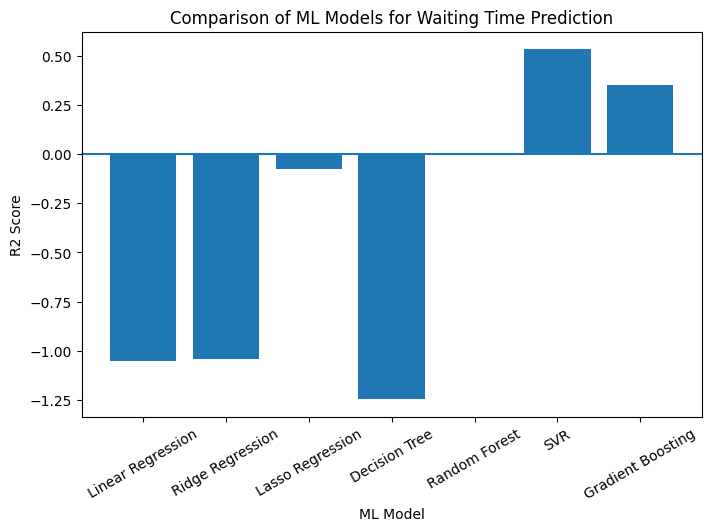

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R2_Score"])
plt.axhline(0)
plt.xticks(rotation=30)
plt.xlabel("ML Model")
plt.ylabel("R2 Score")
plt.title("Comparison of ML Models for Waiting Time Prediction")

plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

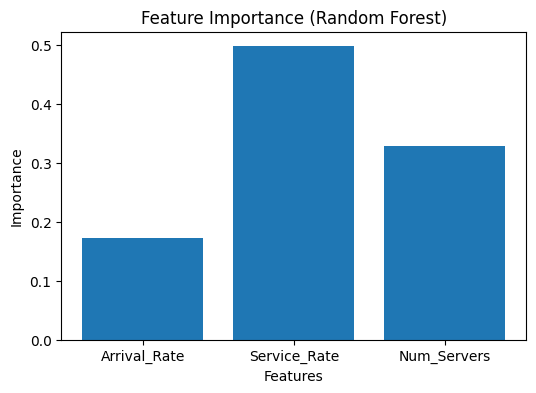

In [20]:
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_

plt.figure(figsize=(6,4))
plt.bar(X.columns, importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")

plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()